# DSCI Group Project -- Group 42

In [3]:
library(tidyverse)
library(dplyr)
library(tidymodels)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Introduction

In 2023, as part of an ongoing exploration into player engagement and behaviour in online gaming environments, UBC students began collecting gameplay-related data to better understand how individuals interact with both in-game features and external community tools. This project aims to identify which types of players are most likely to stay engaged beyond the game itself, through newsletters, and what personal or behavioural characteristics contribute to that engagement.

Online games attract a wide range of players because they allow for diverse play styles including: creative, competitive, social, or exploratory. Research has shown that different demographic and behavioural characteristics shape how players participate in digital spaces. Younger players often interact with fast-paced features more actively (Wohn, 2014), while more experienced players tend to engage more deeply with community-driven aspects of games (Yee, 2006). Although gender differences have also been documented, scholars caution against using gender as a predictive feature in computational models because doing so can reinforce stereotypes and obscure biases within datasets (D’Ignazio & Klein, 2020).
    
These concerns are especially relevant in our dataset, where approximately 70% of the players identify as male. This demographic imbalance introduces a sampling bias that makes gender-based predictions unreliable and ethically questionable. For this reason, gender is included only descriptively in our exploratory analysis and is not used as a predictor variable in our final model.

We were provided with two datasets containing detailed information about players and the worlds they interact with. The Players dataset includes demographic variables (age, gender), behavioural features (total hours played, experience level), and whether a player subscribed to a newsletter. The second dataset, Sessions, contains information about session-level gameplay activity, such as session length, frequency of play, and world type.

Using these datasets, our investigation aims to determine whether certain player characteristics are associated with higher levels of community engagement. More specifically, we ask:
        
        How do player characteristics like total hours played, experience level, and age predict the likelihood of newsletter subscription?

Before modelling, we conducted exploratory data analysis to understand the structure of our data. A bar plot of gender distribution revealed the strong male majority mentioned earlier. A second graph visualizing experience levels (Beginner, Intermediate, Advanced) helped illustrate how players differ in self-reported familiarity with gameplay. We also examined newsletter subscription rates through a simple bar chart, establishing a baseline understanding of engagement with out-of-game communication features. These exploratory graphs provide essential context and help identify which variables may meaningfully relate to newsletter subscription.


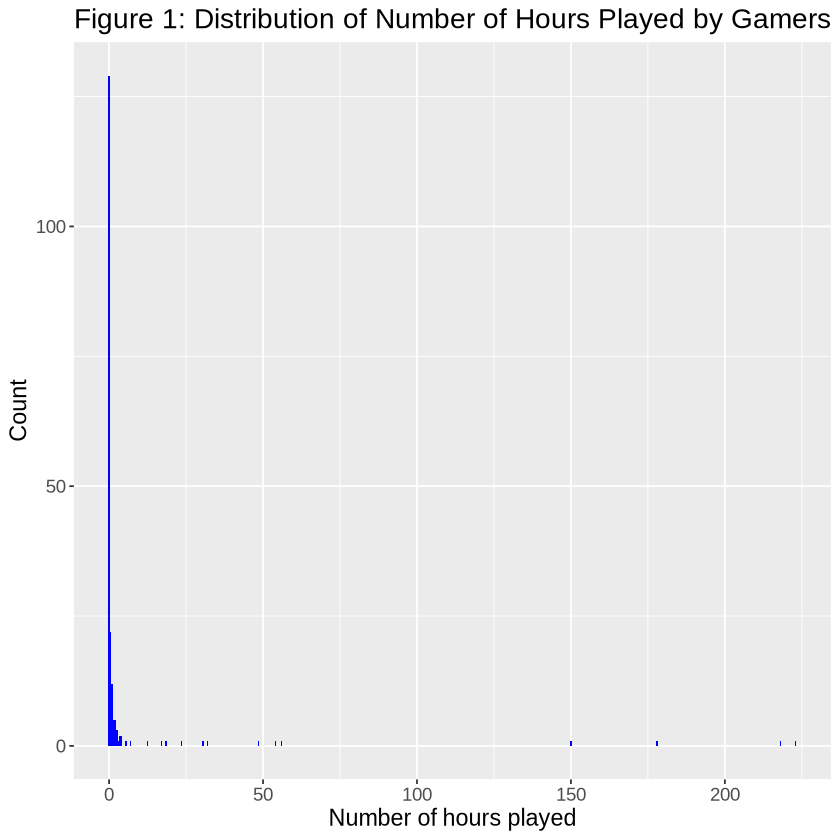

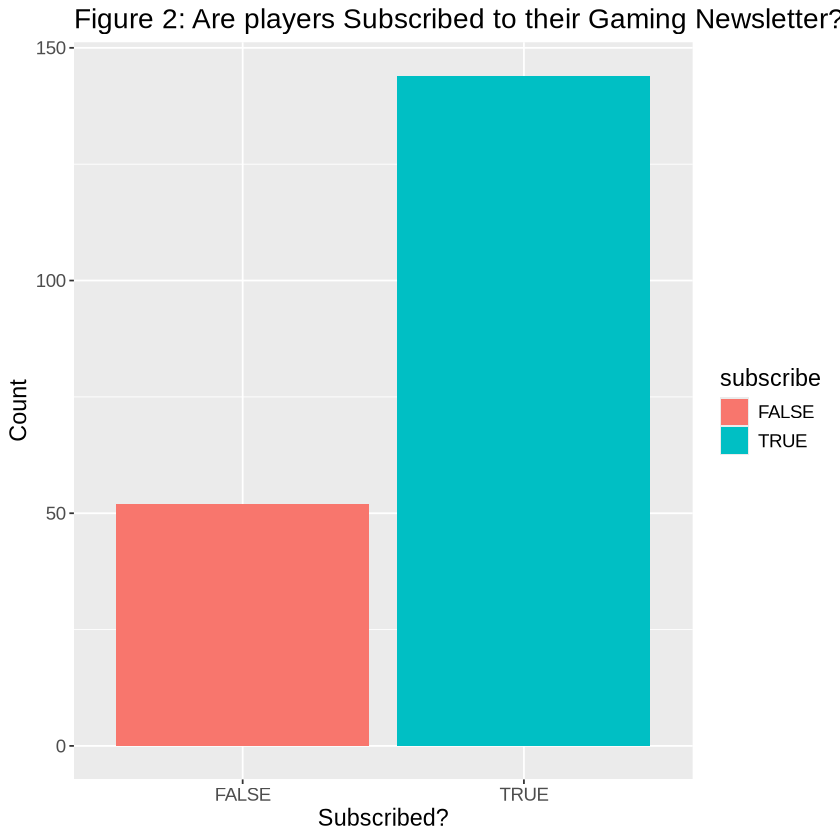

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


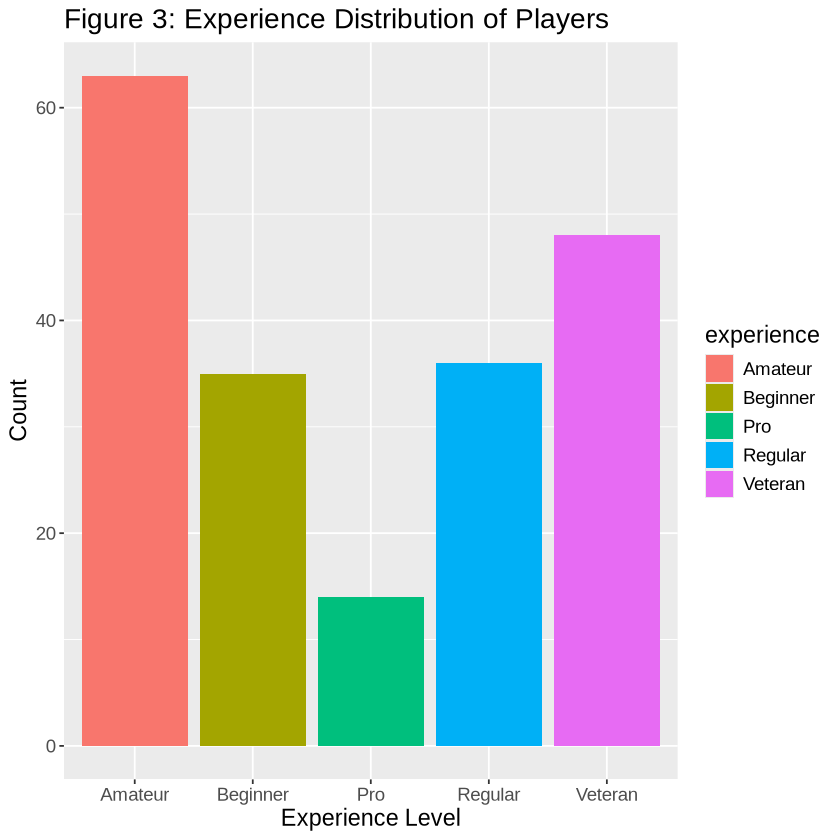

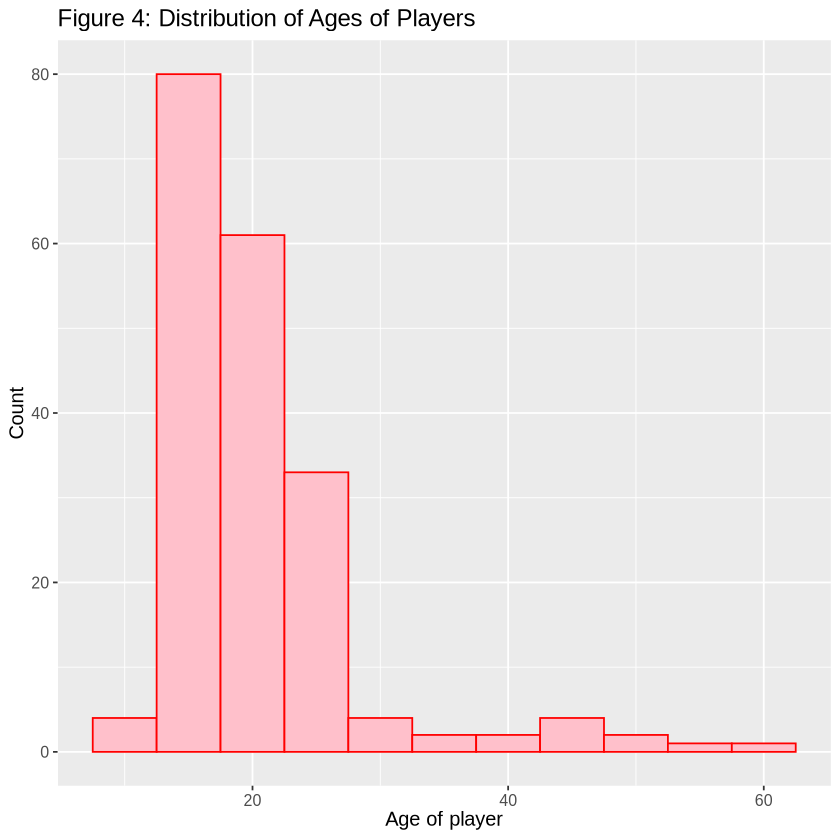

In [7]:
play_distribution <- players |> 
ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 0.5, fill = "blue") +
    labs(x = "Number of hours played", y = "Count") +
    ggtitle("Figure 1: Distribution of Number of Hours Played by Gamers") +
    theme(text = element_text(size = 14))

play_distribution


subscribe <- players |> 
ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Subscribed?", y = "Count") +
    ggtitle("Figure 2: Are players Subscribed to their Gaming Newsletter?") +
    theme(text = element_text(size = 14))
subscribe


experience <- players |> 
    ggplot(aes(x = experience, fill = experience)) +
    geom_bar() +
    labs(title = "Figure 3: Experience Distribution of Players", x = "Experience Level", y = "Count") +
    theme(text = element_text(size = 14)) 
experience

age_distribution <- players |> 
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 5, fill = "pink", color = "red") +
    labs(x = "Age of player", y = "Count") +
    ggtitle("Figure 4: Distribution of Ages of Players") +
    theme(text = element_text(size = 12))

age_distribution


### Data Visualization Analysis

Looking at Figure 1, we can note that our graph is significantly skewed to the right, thus most players only played for a few minutes. With Minecraft being a very long game that requires many different steps and ways to complete the game, having gamers who only played for such brief amounts of time may not make the data very accurate in terms of what true Minecraft gamers look like. Looking at Figure 2, we can see that more than half of the gamers chose to subscribe to the newsletter. Figure 3 shows us that most gamers self-identified as Amateur. Finally, Figure 4 shows us that the majority of gamers were just under 20, probably making them university students.


## Research Question

### How do player characteristics like total hours played, experience level, and age predict the likelihood of newsletter subscription?


Before applying the K-NN algorithm, we first need to set a random seed for reproducibility and clean our dataset.

We will transform the `subscribe` and `experience` variables into factors since they are categorical. We will also remove any irrelevant variables that won't be used in the model. Lastly, we will remove observations with missing values to ensure our dataset is complete and ready for analysis. The cleaned dataset will be stored in the `clean_players` variable!

In [7]:
set.seed(6666)

clean_players <- players |>
    mutate(subscribe = as.factor(subscribe),
           experience = as.factor(experience)) |>
    select(-hashedEmail, -gender, -name) |>
    filter(!is.na(Age)) |>
    filter(!is.na(experience)) |>
    filter(!is.na(subscribe))

head(clean_players)

experience,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Amateur,TRUE,0.0,17


#### Setting Up Training and Testing Data

To start our K-NN classification, we use the `initial_split` function to split our cleaned dataset. 70% of the data will be used for training our model, while the remaining 30% will be used for testing it. We do this because we want to train the algorithm with our data, but still be able to test using the same data.

In [8]:
players_split <- initial_split(clean_players, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#### Creating a Recipe and Model

Our next step is to create a recipe. A recipe defines the preprocessing steps we want to apply to our dataset before executing the analysis. In this case, our target variable is subscribe, and we will use `Age`, `played_hours`, and `experience` as predictor variables. To ensure that no single variable dominates the model due to scale differences, we will scale and center *Age* and *played_hours*. To help our model, we're also going to upsample the *subscribe* variable. This step will prevent the model from being biased towards the majority class (i.e. players who did subscribe).

Finally, we will use the `nearest_neighbors` function to specify that our analysis will use K-NN classification!"

In [9]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_scale(Age, played_hours) |>
    step_center(Age, played_hours) |>
    step_upsample(subscribe, over_ratio = 1, skip = TRUE)
players_recipe

knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec_tuned



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: Age and played_hours

• Centering for: Age and played_hours

• Up-sampling based on: subscribe



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Using 5 Fold Cross Validation and Train the Model

Now, we will set up 5-fold cross-validation for the training set. Cross-validation will evaluate the performance of each model with different k-values by training on a portion of the data and testing it on the remaining part. This process is repeated multiple times to obtain an average result. This step provides a more reliable estimate of our algorithm's ability to predict the `subscribe` variable through its multiple tests. 

We're going to define our grid by giving a large range for the neighbors parameter in our K-NN model. 

Finally, we're going to set up our workflow. We want to combine our recipe, our type of model, and the cross-validation. 

In [69]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

knn_tuned_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_tuned) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()
knn_tuned_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5643875,5,0.04428894,Preprocessor1_Model001
1,roc_auc,binary,0.5452068,5,0.06436307,Preprocessor1_Model001
2,accuracy,binary,0.5347578,5,0.05192225,Preprocessor1_Model002
2,roc_auc,binary,0.5314286,5,0.06989788,Preprocessor1_Model002
3,accuracy,binary,0.4746235,5,0.04997324,Preprocessor1_Model003
3,roc_auc,binary,0.5080169,5,0.07381533,Preprocessor1_Model003
4,accuracy,binary,0.4820309,5,0.05077001,Preprocessor1_Model004
4,roc_auc,binary,0.4862500,5,0.08296925,Preprocessor1_Model004
5,accuracy,binary,0.4751933,5,0.05181377,Preprocessor1_Model005


#### Visualize Accuracy with Different K Values

Now that we've fully trained our model, it's time to visualize the accuracy for each value of k (number of neighbors). To do so, we want to create a plot that visualizes the relationship between k and its accuracy.  

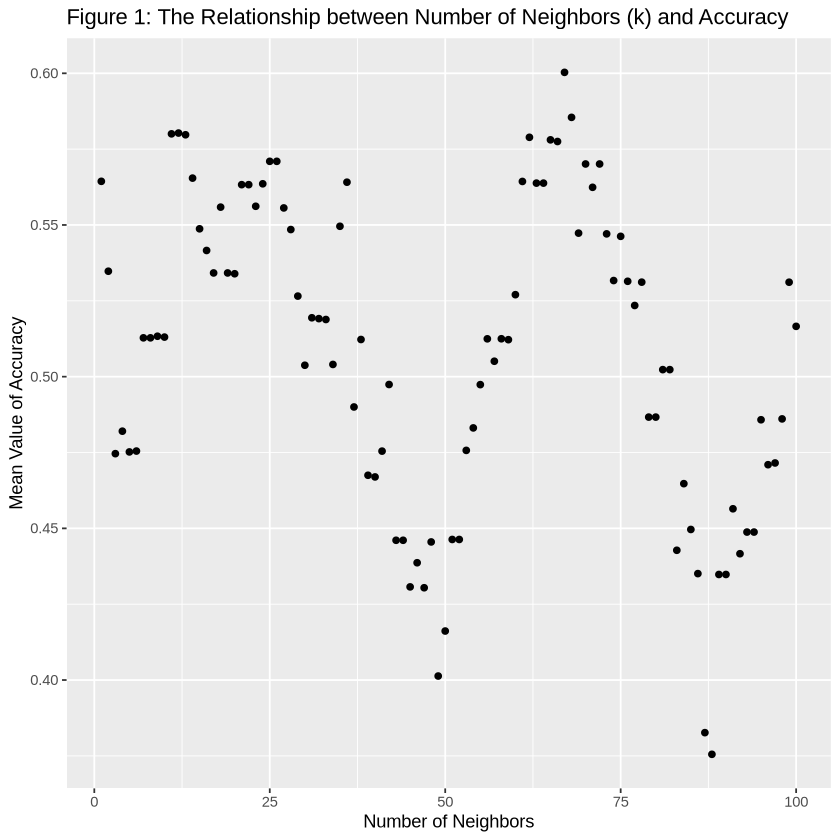

In [70]:
# Filters and selects only rows that are accuracy metric
accuracy <- knn_tuned_fit |>
    filter(.metric == "accuracy")

accuracy_plot <- accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Number of Neighbors",
         y = "Mean Value of Accuracy") +
    ggtitle("Figure 1: The Relationship between Number of Neighbors (k) and Accuracy") +
    theme(text = element_text(size = 11))
accuracy_plot

#### Find the Best K and Fitting it in Training Data

From our visual, we can use the function `slice_max` to find the number of k-neighbors with the highest accuracy. This will also allow us to know the optimal number of neighbours to use in our final model, and we will name this `best_k`. 

With `best_k`, we will specify our optimal model! We'll create our final workflow, which again, will combine all of our previous steps — now with our `best_k`!

In [73]:
# Finding the best number of neighbors for our model
best_k <- accuracy |>
    slice_max(mean) |>
    pull(neighbors)
best_k

# Optimizing model with new value of k
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbor = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Our final workflow!
knn_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_best) |>
    fit(players_test)

[1] 67

#### Predict Using Testing Data

After training the K-NN model with the optimal number of neighbors, We are going to use the test dataset to make predictions on the `subscribe` variable. We're going to evaluate the model’s performance using two metrics: accuracy and kappa. 

In [72]:
subscribe_predictions <- predict(knn_best_fit, players_test) |>
    bind_cols(players_test)

subscribe_metrics <- subscribe_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)

subscribe_metrics
subscribe_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7796610
kap,binary,0.3230362


.pred_class,experience,subscribe,played_hours,Age
<fct>,<fct>,<fct>,<dbl>,<dbl>
TRUE,Veteran,FALSE,0.0,17
TRUE,Amateur,FALSE,0.0,21
TRUE,Pro,TRUE,0.0,17
TRUE,Amateur,TRUE,0.2,22
TRUE,Veteran,TRUE,0.0,17
FALSE,Regular,TRUE,0.3,58
TRUE,Amateur,FALSE,0.1,17
TRUE,Beginner,TRUE,0.0,17
TRUE,Amateur,TRUE,1.8,23


**The model achieves an accuracy of 77.97%**, meaning it correctly predicts the subscription status of players about 78% of the time. 

These results suggest that the model performs well, but there may still be room for improvement in terms of agreement between predicted and true outcomes. 

## References

D’Ignazio, C., & Klein, L. F. (2020). Data Feminism. MIT Press. https://data-feminism.mitpress.mit.edu/

Wohn, D. Y. (2014). Spending real money: Purchasing patterns of virtual goods in an online social game. Computers in Human Behavior, 38, 1–10. https://doi.org/10.1016/j.chb.2014.05.001

Yee, N. (2006). Motivations for play in online games. CyberPsychology & Behavior, 9(6), 772–775. https://doi.org/10.1089/cpb.2006.9.772 